# Predicting tumours using gene expression data

Data source - http://datam.i2r.a-star.edu.sg/datasets/krbd/ColonTumor/ColonTumor.html

In this Notebook, I'll be using gene expression from 2000 different genes from 62 different patients to predict whether or not a person has a cancerous tumour in their colon. Of the 62 patients, 22 have tumours and 40 do not.

I'm going to be using a number of different techniques to predict this binary variable.

## Import libraries

In [94]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import interp
import csv

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.cross_validation import train_test_split, cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.manifold import Isomap, LocallyLinearEmbedding, MDS, TSNE

plt.style.use('bmh')

## Read in data

In [100]:
genes_df = pd.read_csv('/Users/navaneethan/Dropbox/projects/freshdesk/data/genes_data.csv')

The dataset, as mentioned before, contains 62 samples of 2000 gene expression values, plus one column indicating whether the person has a tumour or not

In [98]:
genes_df.shape

(62, 2001)

In [101]:
genes_df['label'].value_counts()

negative    40
positive    22
Name: label, dtype: int64

In [6]:
X, y = genes_df.drop(labels='label', axis=1), genes_df['label']
y = np.where(y == 'positive', 1, 0)

## PCA Analysis

This dataset has far more predictors than it does samples (a case of p >> n). However, given that genes in an individual are likely to be related, we might be able to reduce the dimensionality of the dataset to a more manageable number. Here, with just 15 principal components, we're able to account for 85% of the total variance

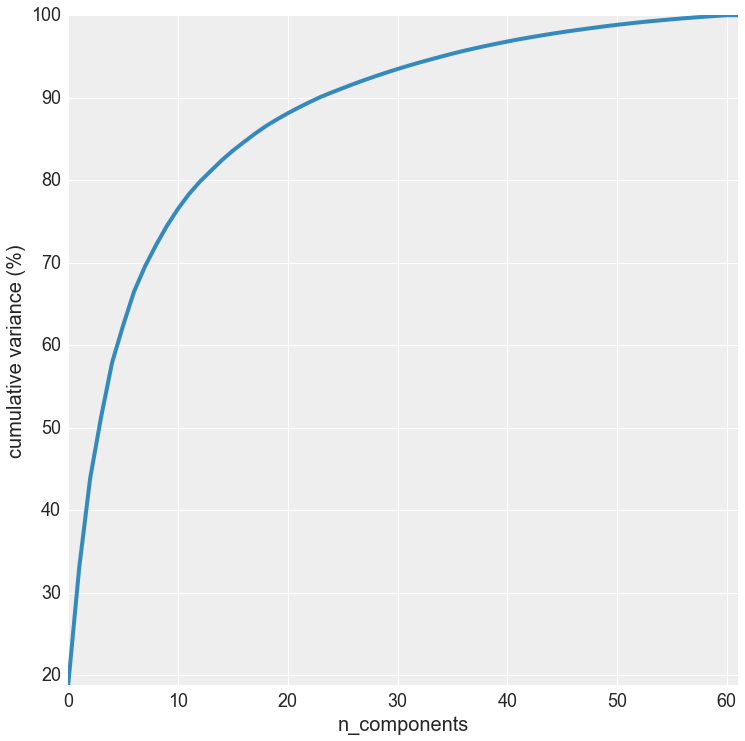

In [105]:
pca = PCA()
X_normalised = normalize(X)
pca.fit(X_normalised)

cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)*100

plt.figure(1, figsize=(12, 12))
plt.clf()
plt.plot(cumulative_variance_explained, linewidth=4)
plt.axis('tight')
plt.xlabel('n_components', fontsize=20)
_ = plt.xticks(fontsize=18)
plt.ylabel('cumulative variance (%)', fontsize=20)
_ = plt.yticks(fontsize=18)

## Model Building & Validation

### Procedure

In this section, I am going to build various models and test to see how well they do. Prior to building the models, I'm going to use various dimensionality reduction techniques to see if there is lower-level structure in the data that can be exploited. One of them, of course is PCA (above). However, apart from PCA, there are techniques that do non-linear dimensionality reduction that we'll be looking at as well.

The general recipe for this is as follows:
 1. Perform a stratified split of the data - since we have imbalanced classes (40:22), we want to make sure that our training and test sets have the same proportion of positive and negative responses. We'll be doing k-fold cross-validation, so we'll be splitting the data into k sets that each maintains roughly the same proportion of positive and negative responses.
 2. Perform dimensionality reduction - we'll be looking at Locally Linear Embedding, Isometric Mapping, and Principal Components Analysis
 3. Train and test the classifier - we'll use a number of different classifiers such as Random Forests, Adaboost, Gradient Boosting Machines, Naive Bayes, Support Vector Machines, and Logistic Regrssion.
 4. Measure classifier performance - we'll be using Area under the Receiver-Operating Characteristic Curve (AUROC or AUC) to see how well the classifier distinguishes between true and false positives. AUC, unlike other measures such as accuracy, is insensitive to class imbalances. In our case, we have a class imbalance (although not severe), so I'd prefer to use this measure.

### `cross_val_model()`

 1. Called with `X` and `y`, the predictors and label respectively. 
 2. Operates in two modes - either with default hyperparameters (`mode='default_params'`) provided to the classifiers, or uses grid search (`mode='grid_search'`) to identify the best combination of hyperparameters. I recognise that there are better techniques, but here we'll be using grid search.
 3. By default, the function evaluates all models (`models=`), or a specific one (`models='random_forest'`). 
 4. The same thing applies to the `reduce_dim` parameter. 
 5. The number of folds can also be specified with a default of 5 (`n_folds=5`).

### Results

The way these results are laid out is as follows - each row represents one kind of model and each column is a different dimensionality reduction technique. The title is formatted as "dimensionality_reduction_technique"+"model". The mean AUC is reported for each combination.

AUC ranges from 0.5 (representing pure chance, there are as many true positives as there are false) to 1 (where it picks only the true positives and none of the false). Higher AUC is therefore better.

As you can see here, AUC is pretty low - it ranges from ~0.4 to ~0.65. The best model looks like a combination of PCA and Gradient Boosting. There are several reasons for this - 
 1. The dataset is very small - we don't have too many samples to generalise from. Maybe different positive tumours have very different gene expressions
 2. The dataset contains a lot of noise - related to being small, the gene expressions may be so variable that finding a pattern is difficult because of a weak signal.

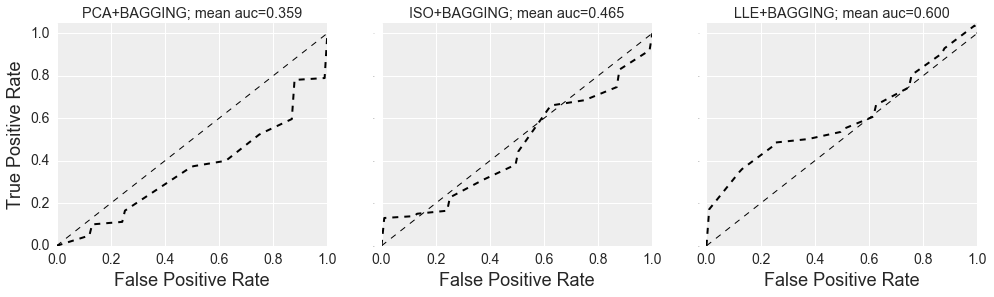

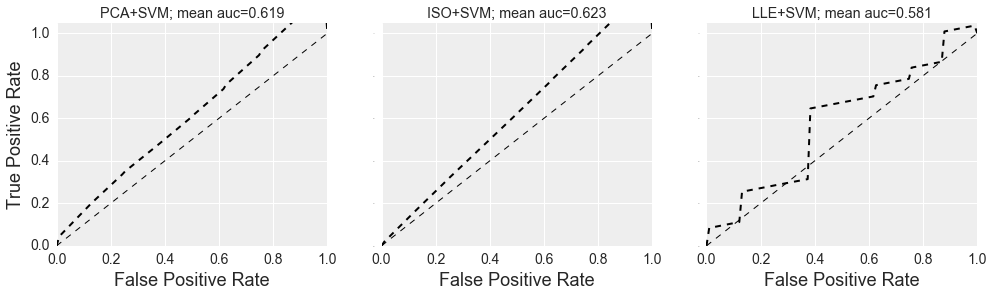

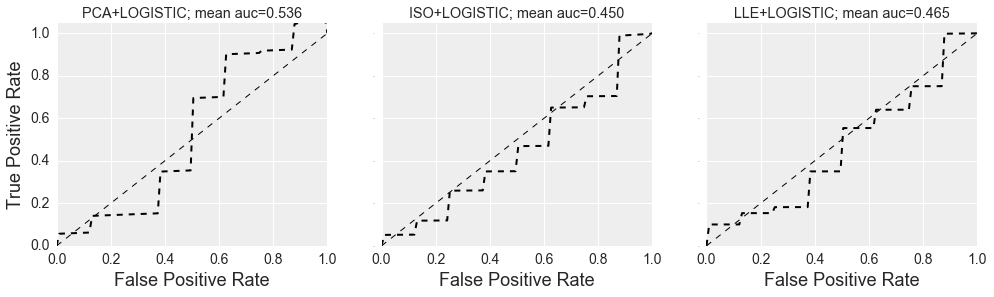

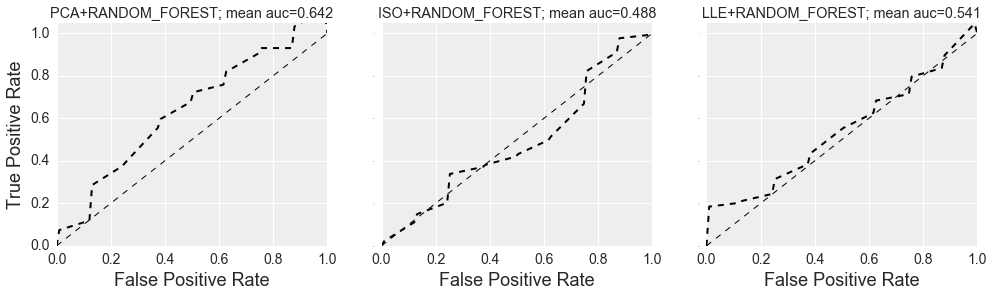

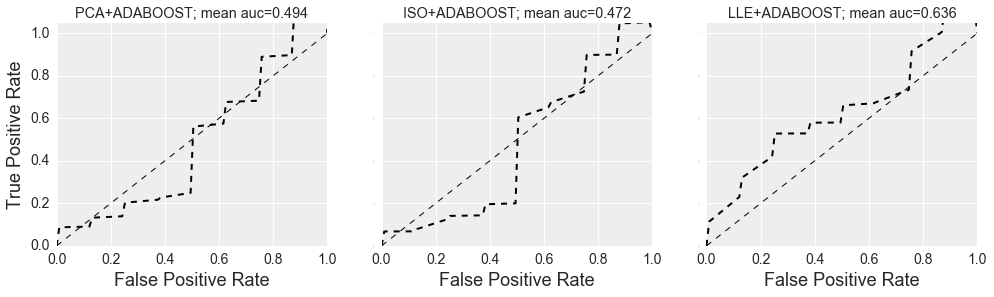

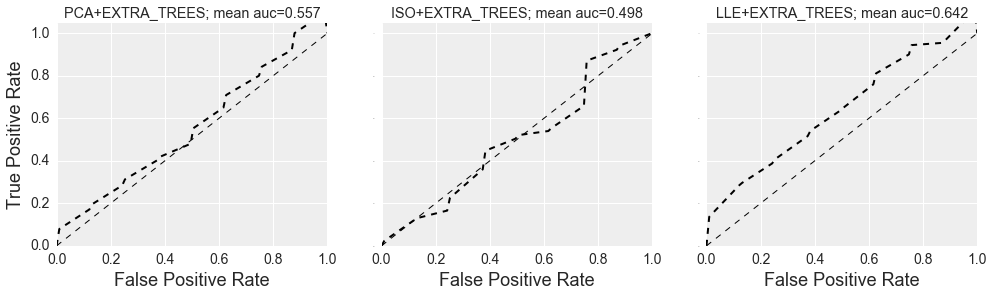

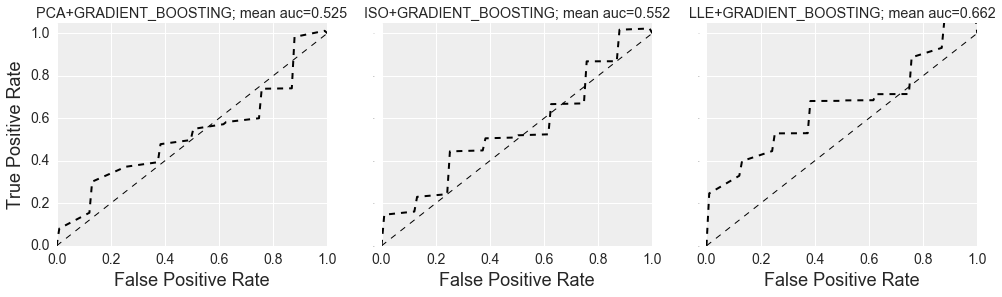

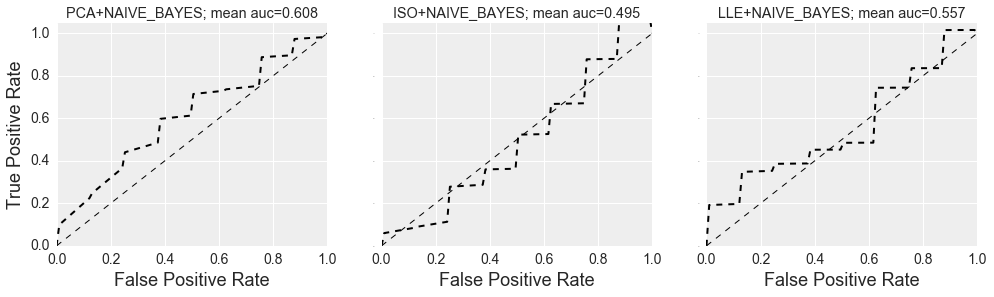

In [103]:
cross_val_model(X=X, y=y, mode='default_params')

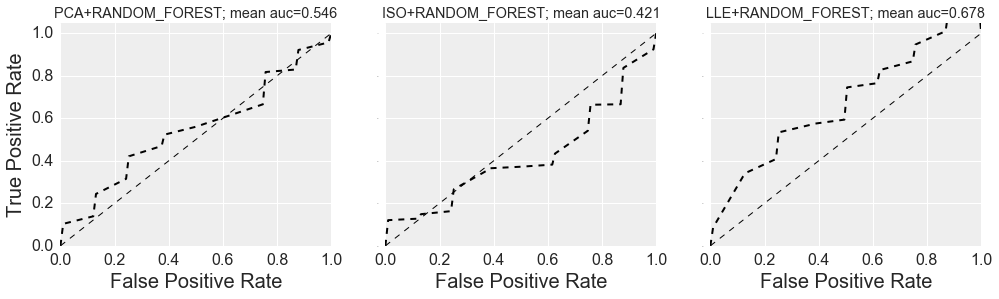

In [96]:
cross_val_model(X=X, y=y, model='random_forest', mode='grid_search')

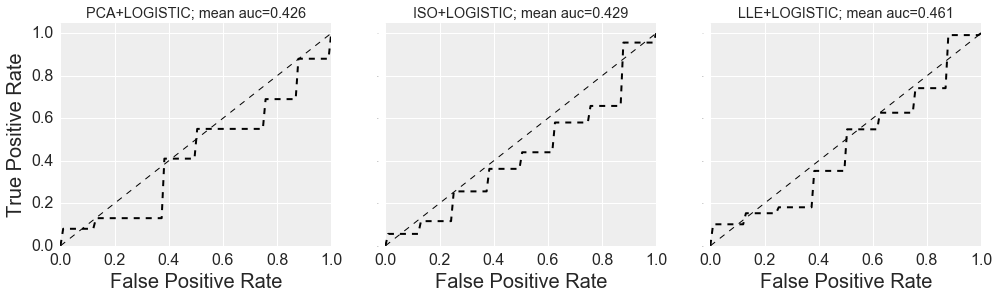

In [82]:
cross_val_model(X=X, y=y, model='logistic', mode='grid_search')

In [102]:
def cross_val_model(X, y, model='', reduce_dim='', n_folds=5, mode='default_params'):
    '''Function to perform dimensionality reduction and build cross-validated models. Reports mean AUC'''
    #cross validation
    skf = StratifiedKFold(y, n_folds=n_folds)
    
    #dimensionality reduction
    pca = PCA()
    iso = Isomap()
    lle = LocallyLinearEmbedding()
    dim_red = {'pca': pca, 'iso': iso, 'lle': lle}
    dr_params = {'pca': {'pca__n_components': [5, 10, 15, 20]},
                 'lle': {'lle__method': ['standard', 'modified', 'ltsa']},
                 'iso': {'iso__neighbors_algorithm':  ['auto', 'brute', 'kd_tree', 'ball_tree']}}

    #algorithms 
    rf = RandomForestClassifier(n_estimators=21, max_features='auto')
    logistic = LogisticRegression()
    nb = GaussianNB()
    ada = AdaBoostClassifier(n_estimators=51)
    gbm = GradientBoostingClassifier(n_estimators=101, max_features='auto')
    svm = SVC(probability=True, kernel='rbf')
    bc = BaggingClassifier(n_estimators=11)
    etc = ExtraTreesClassifier(criterion='entropy')
    models = {'random_forest': rf, 'logistic': logistic, 'naive_bayes': nb, 'adaboost': ada, 
              'gradient_boosting': gbm, 'svm': svm, 'bagging': bc, 'extra_trees': etc}
    #range of parameters for each model so that we can do grid search
    model_params_gridsearch = {
        'random_forest': {'random_forest__n_estimators': [51, 101, 151]},
        'logistic': {'logistic__C': np.logspace(-4, 4, 3)},
        'naive_bayes': {},
        'adaboost': {'adaboost__n_estimators': [51, 101, 151],
                     'adaboost__algorithm': ['SAMME', 'SAMME.R']},
        'gradient_boosting': {'gradient_boosting__n_estimators': [51, 101, 151],
                              'gradient_boosting__loss': ['deviance', 'exponential']},
        'svm': {'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
        'extra_trees': {'extra_trees__n_estimators': [51, 101, 151]},
        'bagging': {'bagging__n_estimators': [51, 101, 151]}
    }

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    #if no model is specified, use all available ones
    if model == '':
        model_keys = models.keys()
    else:
        model_keys = [model] #otherwise use a specific model
    
    for model in model_keys:
        if reduce_dim == '': #if no dimensionality reduction technique is specified, use all available ones
            dim_red_keys = dim_red.keys()
        else:
            dim_red_keys = [reduce_dim] #otherwise use the specified technique
        i = 1
        fig = plt.figure(figsize=(5.5*len(dim_red_keys), 4)) #figure for plotting AUC
        for dr in dim_red_keys:
            for train_index, test_index in skf:
                #generate training and test set
                X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :] 
                y_train, y_test = y[train_index], y[test_index]

                #create a pipeline to run both dimensionality reduction and model building one after another
                pipe = Pipeline(steps=[(dr, dim_red[dr]), (model, models[model])])
                if mode == 'default_params': #if grid_search is not specified
                    pipe.fit(X=X_train, y=y_train)
                    probs = pipe.predict_proba(X_test)
                else: #if grid_search is specified
                    est = GridSearchCV(pipe, (dr_params[dr], model_params_gridsearch[model]))
                    est.fit(X=X_train, y=y_train)
                    probs = est.predict_proba(X_test)
                    
                #Calculate true positives, false positives, and auc
                fpr, tpr, _ = roc_curve(y_test, probs[:, 0])
                roc_auc = auc(fpr, tpr)

                #Calculate the mean true positive rate
                mean_tpr += interp(mean_fpr, fpr, tpr)
                mean_tpr[0] = 0.0
                
            #Generate figure to plot mean auc
            ax = fig.add_subplot(1, len(dim_red_keys), i)
            plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])

            plt.xlabel('False Positive Rate', fontsize=18)
            _ = plt.xticks(fontsize=14)
            if i == 1:
                plt.ylabel('True Positive Rate', fontsize=18)
                _ = plt.yticks(fontsize=14)
            else:
                 plt.ylabel('')
                 _ = plt.yticks(fontsize=0)
            mean_tpr /= len(skf)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            plt.title('{0}+{1}; mean auc={2:0.3f}'.format(dr.upper(), model.upper(), mean_auc))
            plt.plot(mean_fpr, mean_tpr, 'k--')
            i += 1            
        plt.show()